In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

shape_path = 'cb_2018_us_state_20m.shp'

shape = gpd.read_file(shape_path)
print(shape.head())

  STATEFP   STATENS     AFFGEOID GEOID STUSPS          NAME LSAD  \
0      24  01714934  0400000US24    24     MD      Maryland   00   
1      19  01779785  0400000US19    19     IA          Iowa   00   
2      10  01779781  0400000US10    10     DE      Delaware   00   
3      39  01085497  0400000US39    39     OH          Ohio   00   
4      42  01779798  0400000US42    42     PA  Pennsylvania   00   

          ALAND       AWATER  \
0   25151100280   6979966958   
1  144661267977   1084180812   
2    5045925646   1399985648   
3  105828882568  10268850702   
4  115884442321   3394589990   

                                            geometry  
0  MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...  
1  POLYGON ((-96.62187 42.77925, -96.57794 42.827...  
2  POLYGON ((-75.77379 39.72220, -75.75323 39.757...  
3  MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...  
4  POLYGON ((-80.51989 40.90666, -80.51964 40.987...  


In [2]:
shape = shape.dropna()
shape = shape[~shape['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

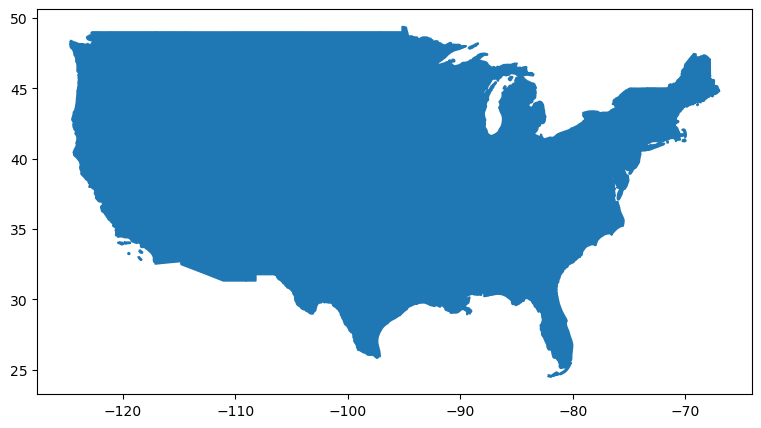

In [3]:
ax = shape.boundary.plot(figsize=(10, 5))
shape.plot(ax=ax, legend=True)

plt.show()

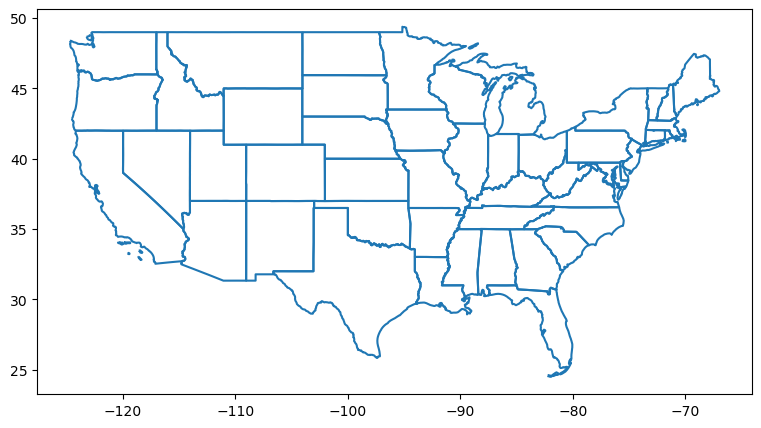

In [4]:
shape.boundary.plot(figsize=(10, 5))
plt.show()

In [5]:
pd_cities = pd.read_csv('test_data_2.csv')
cities = gpd.GeoDataFrame(
    pd_cities, geometry=gpd.points_from_xy(pd_cities.Longitude, pd_cities.Latitude))
cities.crs = 'EPSG:4326'
cities = cities.to_crs(shape.crs)

cities.head()

,Latitude,Longitude,geometry
0,33.60094,-86.95611,POINT (-86.95611 33.60094)


In [9]:
# cities dataframe treatment

uscities = pd.read_csv('uscities.csv')

uscities = uscities[["city", "state_id", "lat", "lng"]]

uscities.head()

,city,state_id,lat,lng
0,City of Industry,CA,34.0050,-117.939
1,Avon,CT,41.7944,-72.8578
2,Branford,CT,41.2778,-72.7997
3,Cromwell,CT,41.5950,-72.6453
4,East Windsor,CT,41.9167,-72.5578


In [11]:
# checking cities btw the two df (uscities and modified fandom)

df = pd.read_csv(r'C:\Users\inesn\Documents\Mines\2A\TR\econometrics\data_collection\plein_de_data\fandom_traitées.csv', parse_dates = ["Opening_date", "Closing_date"])

n_tot = 0
for state in df.State.unique():
    for city in df[df.State == state].Town.unique():
        if city not in uscities[uscities.state_id == state].city.unique() :
            n_tot+=1
print(n_tot)

0


In [73]:
df = pd.read_csv(r'C:\Users\inesn\Documents\Mines\2A\TR\econometrics\data_collection\plein_de_data\fandom_traitées.csv', parse_dates = ["Opening_date", "Closing_date"])

#modifying fandom df

#Store_id,State,Town,Street,Category,Opening_date,Closing_date

#creating boolean columns for entry/exit in 2016 (no entry and exit in 2016 for a single store)
df['opened_2016'] = (df.Opening_date>='2016-01-31')&(df.Opening_date<'2017-01-31')
df['closed_2016'] = (df.Closing_date>='2016-01-31')&(df.Closing_date<'2017-01-31')

#keeping only stores with entry/exit in 2016
df = df[df.opened_2016 | df.closed_2016]
df.describe()


,County_fips,Town_lat
count,114.000000,114.000000
mean,29291.000000,33.658012
std,17691.069885,4.712336
min,1069.000000,26.029300
25%,12095.000000,30.129025
50%,34025.000000,33.565700
75%,48028.500000,35.948700
max,51820.000000,58.454600


In [78]:
#designing the red-orange-green color code

df2 = df.groupby(['Town','State'])['opened_2016'].count().rename('opened_2016_city').to_frame()
#df3 = df.groupby(['Town','State'])['closed_2016'].any().rename('closed_2016_city').to_frame()
#df4 = df2.merge(df3, how = "outer", on = ['Town','State'])
#df4['opened_and_closed_2016_city']=df4.opened_2016_city & df4.closed_2016_city
#df4.head()
df2.head()

,,opened_2016_city
Town,State,
Abilene,TX,1
Abingdon,VA,1
Adel,GA,1
Alamogordo,NM,1
Aurora,IL,1


In [76]:
df5 = df4.merge(df, how = "outer", on = ['Town','State'])
df5=df5[['Town','State','opened_2016_city','closed_2016_city','opened_and_closed_2016_city']]
#aggregation_functions = {'Town': 'first', 'State': 'second', 'opened_2016_city': 'third' ,'closed_2016_city': 'fourth','opened_and_closed_2016_city': 'fifth','town': 'sum'}
#df_new = df5.groupby(df5[['Town','State']]).aggregate(aggregation_functions)
df5.describe()

,Town,State,opened_2016_city,closed_2016_city,opened_and_closed_2016_city
count,114,114,114,114,114
unique,99,27,2,2,1
top,San Antonio,TX,True,False,False
freq,5,24,108,108,114


In [39]:
#merging the 2 dfs

map_data = pd.merge(df5, uscities,  how='inner', left_on=['Town','State'], right_on = ['city','state_id'])

#removing unnecessary columns ('Town', 'State')

map_data = map_data[['city','lat','lng','opened_2016_city','closed_2016_city','opened_and_closed_2016_city']]

def colors(x):
    if x == 1 :
        return 'g'
    if x == 2 :
        return 'r'
    return 'b'

colors_v = np.vectorize(colors)

map_data['value']= 1*map_data['opened_2016_city']+2*map_data['closed_2016_city']+3*map_data['opened_and_closed_2016_city']
map_data['color']=colors_v(map_data['value'])
map_data.describe()



,lat,value
count,313.000000,313.000000
mean,34.163656,1.511182
std,3.983202,0.665570
min,25.997500,1.000000
25%,31.577600,1.000000
50%,34.114100,1.000000
75%,35.975100,2.000000
max,58.454600,6.000000


### New code for the map

In [158]:
df = pd.read_csv(r'C:\Users\inesn\Documents\Mines\2A\TR\econometrics\data_collection\plein_de_data\fandom_traitées.csv', parse_dates = ["Opening_date", "Closing_date"])

In [159]:
#creating boolean columns for entry/exit in 2016 (no entry and exit in 2016 for a single store)
df['opened_2016'] = (df.Opening_date>='2016-01-31')&(df.Opening_date<='2017-01-31')
df['closed_2016'] = (df.Closing_date>='2016-01-31')&(df.Closing_date<='2017-01-31')

In [160]:
#keeping only stores with entry/exit in 2016
df = df[df.opened_2016 | df.closed_2016]
df.describe()

,County_fips,Town_lat
count,116.000000,116.000000
mean,29246.775862,33.676777
std,17772.088098,4.677933
min,1069.000000,26.029300
25%,12095.000000,30.264475
50%,34025.000000,33.565700
75%,48029.000000,35.981900
max,51820.000000,58.454600


In [161]:
#designing the red-orange-green color code

#assuming that there isn't 2 cities with same name in same state in our database
df_test = df.groupby(['Town','State'])['Store_id'].count()
df_test.describe()

count    102.000000
mean       1.137255
std        0.508136
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        5.000000
Name: Store_id, dtype: float64

<AxesSubplot: >

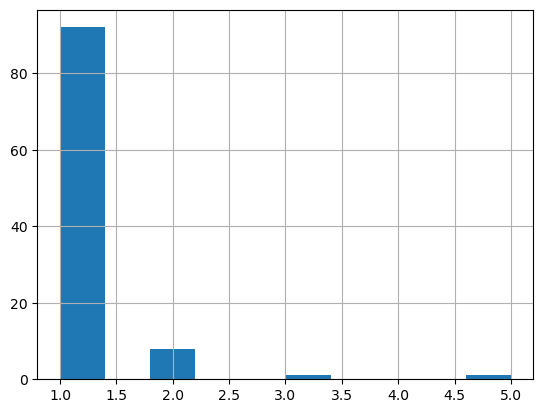

In [162]:
df_test.hist()

In [163]:
df.describe()

,County_fips,Town_lat
count,116.000000,116.000000
mean,29246.775862,33.676777
std,17772.088098,4.677933
min,1069.000000,26.029300
25%,12095.000000,30.264475
50%,34025.000000,33.565700
75%,48029.000000,35.981900
max,51820.000000,58.454600


In [164]:
#designing the red-orange-green color code
df2 = df.groupby(['Town','State'])['opened_2016'].any().rename('opened_2016_city').to_frame()
df2.describe()

,opened_2016_city
count,102
unique,2
top,True
freq,95


In [165]:
df3 = df.groupby(['Town','State'])['closed_2016'].any().rename('closed_2016_city').to_frame()
df3.describe()

,closed_2016_city
count,102
unique,2
top,False
freq,95


In [166]:
df4 = df2.merge(df3, how = "outer", on = ['Town','State'])
df4.describe()

,opened_2016_city,closed_2016_city
count,102,102
unique,2,2
top,True,False
freq,95,95


In [167]:
def colors(x):
    if x == 1 :
        return 'g'
    if x == 2 :
        return 'r'
    return 'b'

colors_v = np.vectorize(colors)
df4['color']= colors_v(1*df4['opened_2016_city']+2*df4['closed_2016_city'])
df4.describe()

,opened_2016_city,closed_2016_city,color
count,102,102,102
unique,2,2,2
top,True,False,g
freq,95,95,95


In [168]:
map_data = pd.merge(df4, uscities,  how='inner', left_on=['Town','State'], right_on = ['city','state_id'])
map_data.head()
#df5=df5[['Town','State','opened_2016_city','closed_2016_city','opened_and_closed_2016_city']]
map_data.head()

,opened_2016_city,closed_2016_city,color,city,state_id,lat,lng
0,True,False,g,Abilene,TX,32.4543,-99.7384
1,True,False,g,Abingdon,VA,36.7090,-81.9713
2,True,False,g,Adel,GA,31.1264,-83.4229
3,True,False,g,Alamogordo,NM,32.8837,-105.9625
4,False,True,r,Aurora,IL,41.7638,-88.2902


In [172]:
geo_map_data = gpd.GeoDataFrame(
    map_data, geometry=gpd.points_from_xy(map_data.lng, map_data.lat))
geo_map_data.crs = 'EPSG:4326'
geo_map_data = geo_map_data.to_crs(shape.crs)

geo_map_data.head()


,opened_2016_city,closed_2016_city,color,city,state_id,lat,lng,geometry
0,True,False,g,Abilene,TX,32.4543,-99.7384,POINT (-99.73840 32.45430)
1,True,False,g,Abingdon,VA,36.7090,-81.9713,POINT (-81.97130 36.70900)
2,True,False,g,Adel,GA,31.1264,-83.4229,POINT (-83.42290 31.12640)
3,True,False,g,Alamogordo,NM,32.8837,-105.9625,POINT (-105.96250 32.88370)
4,False,True,r,Aurora,IL,41.7638,-88.2902,POINT (-88.29020 41.76380)


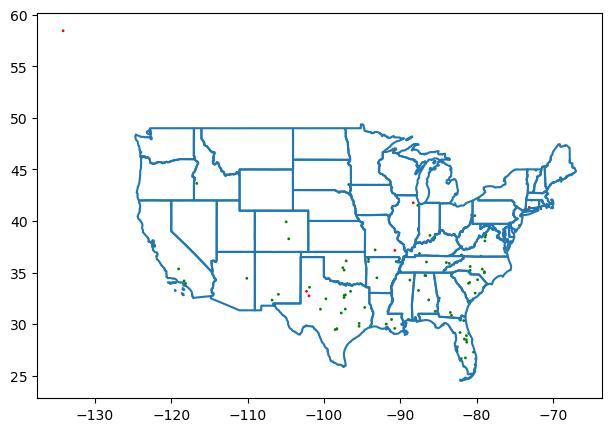

In [177]:
base = shape.boundary.plot(figsize=(10, 5))

geo_map_data.plot(ax=base, marker='o', color=geo_map_data['color'], markersize=1);

geo_map_data.explore()

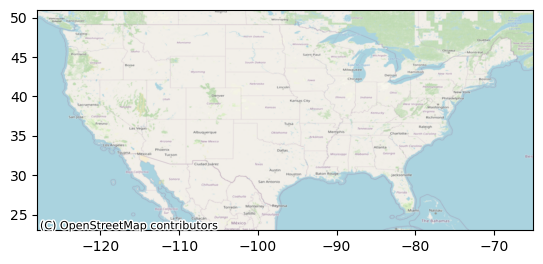

In [14]:
import geopandas as gpd
import contextily as cx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as pa
from matplotlib.lines import Line2D

long_min = - 128
long_max = -65
lat_min = 23
lat_max = 51

#collecte de la dataframe...
df = pd.read_csv('test_data.csv', parse_dates = ["Opening_date", "Closing_date"])
df = df[['Latitude', 'Longitude', 'State']]
df.head()

#conversion en geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs='EPSG:4326')

#création des couleurs/tailles de points
def couleur(a): # couleur d'un point du graphique en fonction de a la date du séisme en km
    if a == "opened":
        return 'purple'
    elif a == "closed":
        return 'blue'
    elif a == "opened-closed":
        return 'green'
    return 'yellow'

vcouleur = np.vectorize(couleur)

color=vcouleur(df['State'])

fig, ax = plt.subplots() #gdf.plot(kind='scatter', y='Latitude', x='Longitude', s=magn_2, c=prof, edgecolors='k', linewidth = 0.6)
ax.set_xlim(long_min, long_max)
ax.set_ylim(lat_min, lat_max)
cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.OpenStreetMap.Mapnik) #OpenStreetMap.Mapnik

line1 = Line2D(range(1), range(1), color="purple", marker='o', markerfacecolor="purple")
line2 = Line2D(range(1), range(1), color="blue", marker='o',markerfacecolor="blue")
line3 = Line2D(range(1), range(1), color="cyan", marker='o', markerfacecolor="cyan")
line4 = Line2D(range(1), range(1), color="green", marker='o',markerfacecolor="green")
line5 = Line2D(range(1), range(1), color="yellow", marker='o',markerfacecolor="yellow")
#plt.legend((line1,line2,line3,line4, line5),('< 2 km', '2-4 km', '4-6 km', '6-8 km', '8-10 km'),numpoints=1, loc='lower right',title = 'Profondeur',borderpad = 0.5, labelspacing = 0.5)

plt.show()

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as pa
from matplotlib.lines import Line2D

long_min = - 128
long_max = -65
lat_min = 23
long_max = 51

#collecte de la dataframe...
df = pd.read_csv('test_data.csv', parse_dates = ["Opening_date", "Closing_date"])

df.head()

,Store_id,State,Town,Street,Category,Opening_date,Closing_date,Latitude,Longitude,State
0,1158,AL,Adamsville,2473 Hackworth Rd.,Walmart Supercenter,1988-03-01,NaT,33.60094,-86.95611,"""opened"""


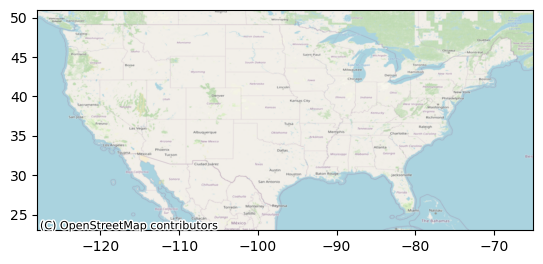

In [16]:
import geopandas as gpd
import contextily as cx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as pa
from matplotlib.lines import Line2D

long_min = - 128
long_max = -65
lat_min = 23
lat_max = 51

#collecte de la dataframe...
df = pd.read_csv('test_data.csv', parse_dates = ["Opening_date", "Closing_date"])
df = df[['Latitude', 'Longitude', 'State']]
df.head()

#conversion en geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs='EPSG:4326')

fig, ax = plt.subplots() #gdf.plot(kind='scatter', y='Latitude', x='Longitude', s=magn_2, c=prof, edgecolors='k', linewidth = 0.6)
ax.set_xlim(long_min, long_max)
ax.set_ylim(lat_min, lat_max)
cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.OpenStreetMap.Mapnik) #OpenStreetMap.Mapnik

plt.show()